# LinkNet: Network for Semantic Segmentation

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

LinkNet architecture is inspired by auto-encoders: each encoder (decoder) performs downsampling (upsampling) the feature maps by a factor of 2. At the same time the number of channels increases (decreases) except the outputs of the first encoder-decoder blocks. The main novelty of LinkNet as a segmenation network is a usage of skip connections between encoders and decoders. This
approach enables to save spatial information that contains in input image and helps to train neural networks. Each convolutional layer is followed by batch-normalization and ReLU. 

<img src='./pic/01.PNG' width="400" height="300">

<img src='pic/02.PNG' width="1000" height="400">

We will use LinkNet to segmenation of $128 \times 128$ images with MNIST $28 \times 28$ at random place (uniformly sampled) with noise generated on the base of MNIST fragments. Each fragment is randomly cutted from random image from the same batch and is rotated by an angle $ \sim U(0,360^{\circ})$. Coordinates of top-left corner are sampled from uniform $U(0, 128-s)$ or normal $N\left(\frac{128-s}{2}, \left(\frac{128-s}{4}\right)^2\right)$ distribution where $s$ is equal to width (height) of rotated image.

In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append("..")
from dataset import Pipeline, DatasetIndex, Dataset

from linknet_model import LinkNetModel                                  # TFModel subclass with LinkNet
from nmnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted # plot functions to demonstrate result 

Fix constants to generate noised images and train LinkNet:

In [2]:
IMAGE_SIZE = 128     # image size
MNIST_SIZE = 65000   # MNIST database size
BATCH_SIZE = 256     # batch size for NN training
MAX_ITER = 300       # number of iterations for NN training

Define noise parameters:

In [3]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 60    # number of noise fragments per image  
size = 8            # size of noise fragment; 1, ..., 27
distr = 'normal'    # distribution of fragments of image; 'uniform' or 'normal'

Create DatasetIndex and Dataset to use pipelines:

In [4]:
ind = DatasetIndex(np.arange(MNIST_SIZE))          # index for images
mnistset = Dataset(ind, batch_class=NoisedMnist)   # Dataset with transform actions in NoisedMnist class
mnistset.cv_split([0.9, 0.1])                      # divide it into train and test

Сreate Pipeline template for image loading and transformation. The first parameter of create_noise is the type of noise: 'mnist_noise' - MNIST-based noise, 'random_noise' - uniform random noise.

In [5]:
load_template = (Pipeline()
                 .load_images()                    # load MNIST images from file
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .create_mask()                    # create mask for MNIST image location
                 .create_noise('mnist_noise',
                            level,
                            n_fragments, 
                            size, 
                            distr))

Plot example of noised images (train images are greyscale but we highlight true digit in yellow to plot):

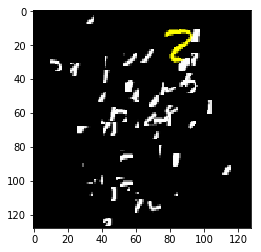

In [6]:
images = []
noise = []
(load_template << mnistset.train).get_images(images).get_noise(noise).next_batch(10, shuffle=True)
plot_noised_image(images[0][0], noise[0][0])

Create feed_dict's for TFModel. 
* '<b>image</b>' - name of input placeholdes described in TFModel
* '<b>images</b>' - name of attribute in NoisedMnist class
* '<b>mask</b>' - name of target placeholdes described in TFModel
* '<b>masks</b>' - name of attribute in NoisedMnist class
* '<b>mode</b>' - name of placeholdes for batch normalization training parameter 

In [7]:
train_feed_dict = {'image': 'images',
                  'mask': 'masks',
                  'mode': True}        

test_feed_dict = {'image': 'images',
                  'mask': 'masks',
                  'mode': False}

Create train and test pipelines:

In [8]:
ppl_train = ((load_template << mnistset.train)
            .add_noise()
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static',                                          # model mode
                        LinkNetModel,                                      # TFModel subclass with LinkNet
                        'linknet',                                         # model name
                        config={'loss': 'sigmoid_cross_entropy',
                                'optimizer': 'Adam',
                                'image_size': IMAGE_SIZE})
            .train_model('linknet',                                        # model name
                         fetches='loss',                                   # tensors to get value 
                         feed_dict=train_feed_dict,                        
                         append_to='train_loss_history'))                  # name of pipeline variable to save loss value

ppl_test = ((load_template << mnistset.test)
            .add_noise()
            .import_model('linknet', ppl_train)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('linknet', 
                           fetches='loss',
                           feed_dict=test_feed_dict,
                           append_to='test_loss_history'))

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


Train LinkNet on noised data:

In [9]:
# training of the model

start = time()

for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None)                              # training step
    ppl_test.next_batch(100, n_epochs=None)                                      # compute test loss
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]                # get current iteration train loss
    test_loss = ppl_test.get_variable('test_loss_history')[-1]                   # get current iteration test loss
    
    if (i+1) % 10 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, train_loss, test_loss))
        
stop = time()

print("Train time: {:05.3f} min".format((stop-start)/60))

Iter  10: train 1.255 test 1.229
Iter  20: train 1.108 test 1.076
Iter  30: train 0.978 test 0.960
Iter  40: train 0.861 test 0.841
Iter  50: train 0.755 test 0.740
Iter  60: train 0.657 test 0.652
Iter  70: train 0.572 test 0.566
Iter  80: train 0.498 test 0.495
Iter  90: train 0.438 test 0.431
Iter 100: train 0.387 test 0.380
Iter 110: train 0.341 test 0.336
Iter 120: train 0.302 test 0.300
Iter 130: train 0.271 test 0.266
Iter 140: train 0.245 test 0.237
Iter 150: train 0.218 test 0.219
Iter 160: train 0.200 test 0.201
Iter 170: train 0.184 test 0.181
Iter 180: train 0.166 test 0.166
Iter 190: train 0.153 test 0.153
Iter 200: train 0.140 test 0.141
Iter 210: train 0.130 test 0.128
Iter 220: train 0.121 test 0.120
Iter 230: train 0.118 test 0.113
Iter 240: train 0.106 test 0.106
Iter 250: train 0.102 test 0.104
Iter 260: train 0.095 test 0.093
Iter 270: train 0.094 test 0.090
Iter 280: train 0.088 test 0.089
Iter 290: train 0.080 test 0.081
Iter 300: train 0.080 test 0.075
Train time

Plot train and test loss:

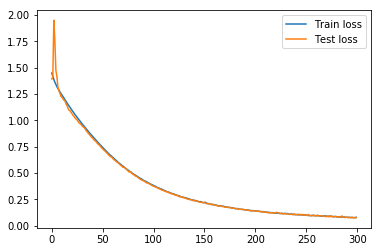

In [10]:
plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_train.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()

Create pipeline to get some images from test dataset and corresponding masks, noise and mask predictions:

In [11]:
images = []
masks = []
noise = []

ppl_plot = ((load_template << mnistset.test)                       # load data from file
             .get_images(images)                                   # images without noise
             .get_masks(masks)                                     # get masks
             .get_noise(noise)                                     # get noise
             .add_noise()                                          # add noise to images
             .import_model('linknet', ppl_train)
             .init_variable('predictions', init_on_each_run=list)
             .predict_model('linknet',                                      
                           fetches='predicted_prob',
                           feed_dict=test_feed_dict,
                           append_to='predictions'))

Get predictions for 10 images:

In [12]:
ppl_plot.next_batch(10, n_epochs=None)
predictions = ppl_plot.get_variable('predictions')[-1]

Plot images with highlighted digit, mask for $28 \times 28$ image, binary mask prediction and probability prediction:

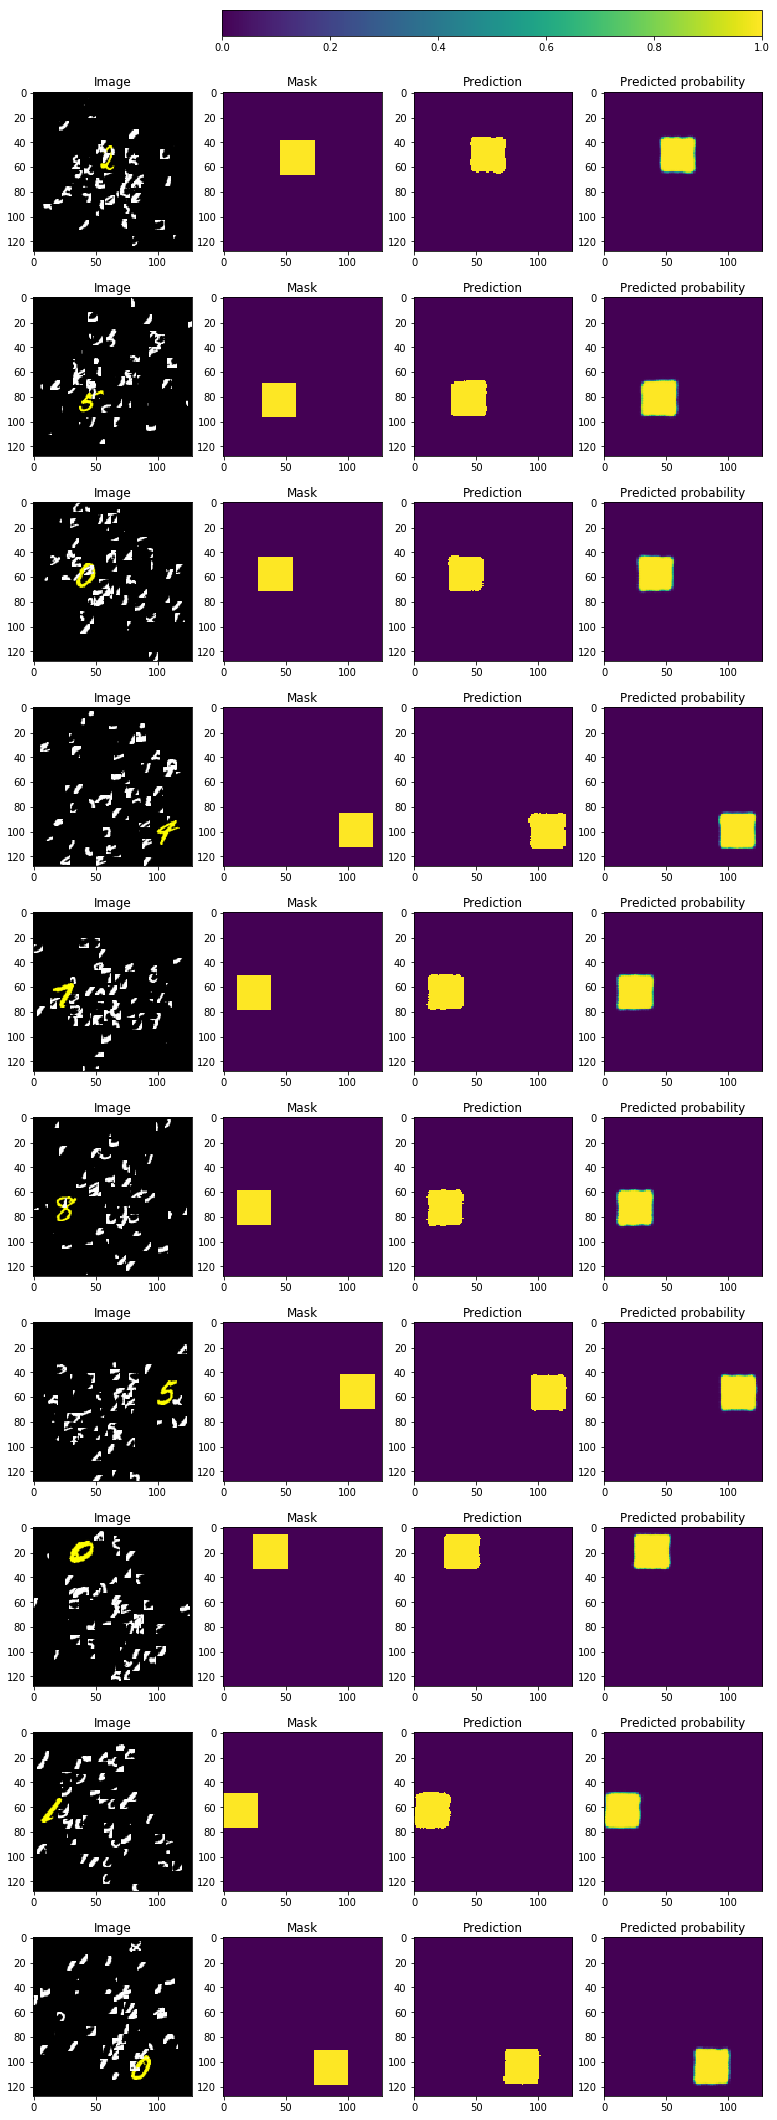

In [13]:
plot_examples_highlighted(images, noise, masks, predictions)